In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = pd.melt(data,id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-07-31   AAPL  195.412216  196.449997  196.490005  195.259995   
1         2023-07-31   GOOG  132.958694  133.110001  133.830002  132.130005   
2         2023-07-31   MSFT  333.312622  335.920013  337.700012  333.359985   
3         2023-07-31   NFLX  438.970001  438.970001  439.130005  426.299988   
4         2023-07-31   TSLA  267.429993  267.429993  269.079987  263.779999   

Attribute        Open      Volume  
0          196.059998  38824100.0  
1          133.009995  18381900.0  
2          336.920013  25446000.0  
3          426.510010   6587600.0  
4          267.480011  84582200.0  


In [2]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-07-31   AAPL  195.412216  196.449997  196.490005  195.259995  196.059998   
2023-07-31   GOOG  132.958694  133.110001  133.830002  132.130005  133.009995   
2023-07-31   MSFT  333.312622  335.920013  337.700012  333.359985  336.920013   
2023-07-31   NFLX  438.970001  438.970001  439.130005  426.299988  426.510010   
2023-07-31   TSLA  267.429993  267.429993  269.079987  263.779999  267.480011   

Attribute       Volume  
Date                    
2023-07-31  38824100.0  
2023-07-31  18381900.0  
2023-07-31  25446000.0  
2023-07-31   6587600.0  
2023-07-31  84582200.0  


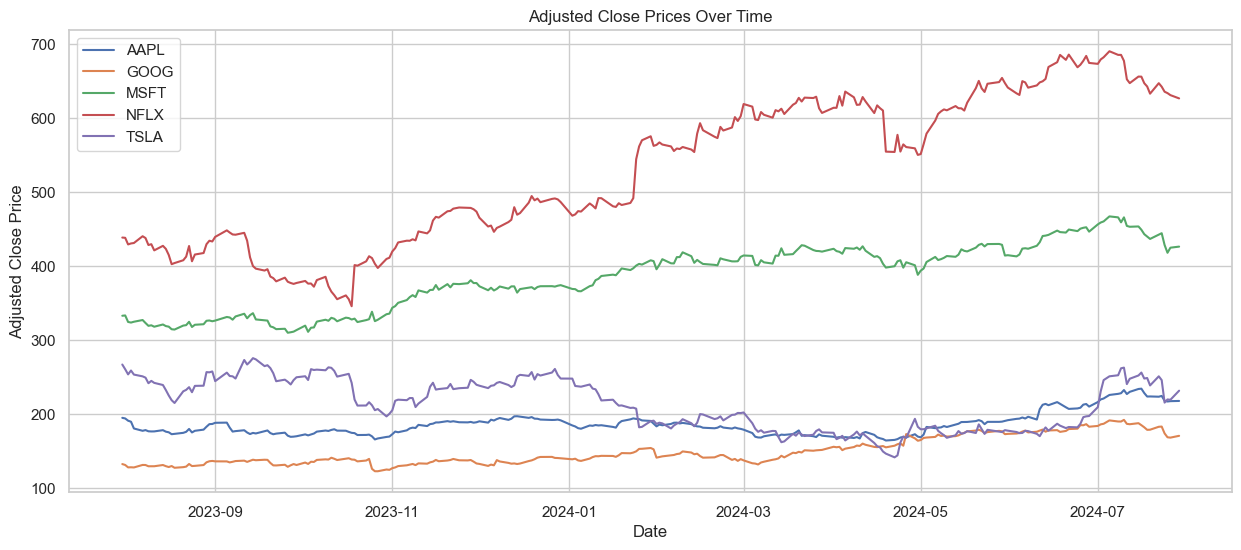

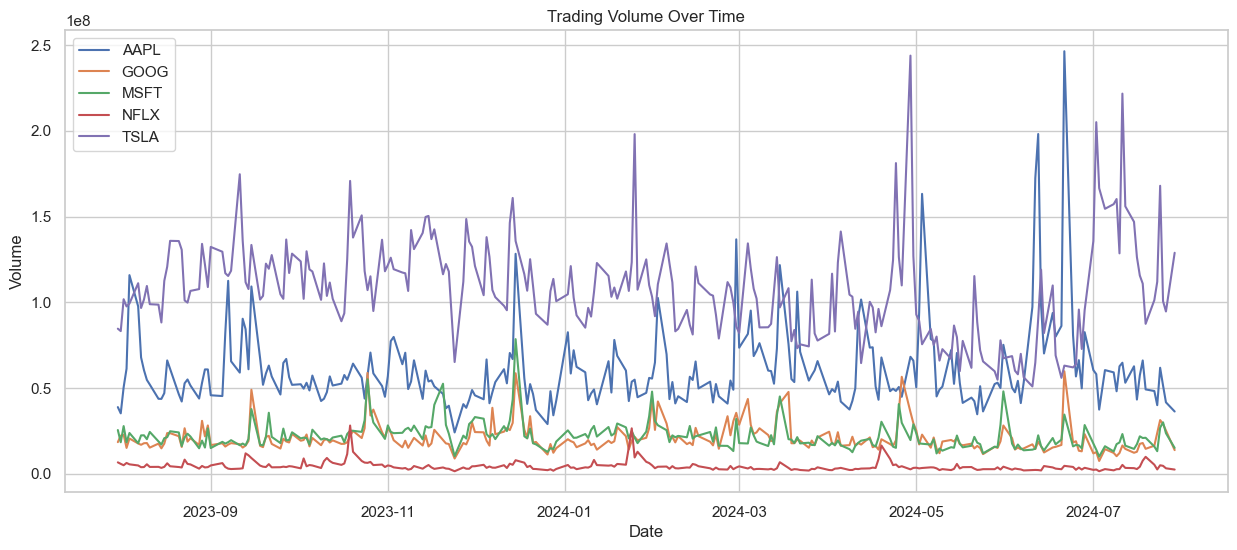

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [4]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-07-02   AAPL  220.270004  220.270004  220.380005  215.100006  216.149994   
2024-07-03   AAPL  221.550003  221.550003  221.550003  219.029999  220.000000   
2024-07-05   AAPL  226.339996  226.339996  226.449997  221.649994  221.649994   
2024-07-08   AAPL  227.820007  227.820007  227.850006  223.250000  227.089996   
2024-07-09   AAPL  228.679993  228.679993  229.399994  226.369995  227.929993   

Attribute       Volume   Z-score  
Date                              
2024-07-02  58046200.0  2.175240  
2024-07-03  37369800.0  2.257340  
2024-07-05  60412400.0  2.564573  
2024-07-08  59085900.0  2.659502  
2024-07-09  48076100.0  2.714662  


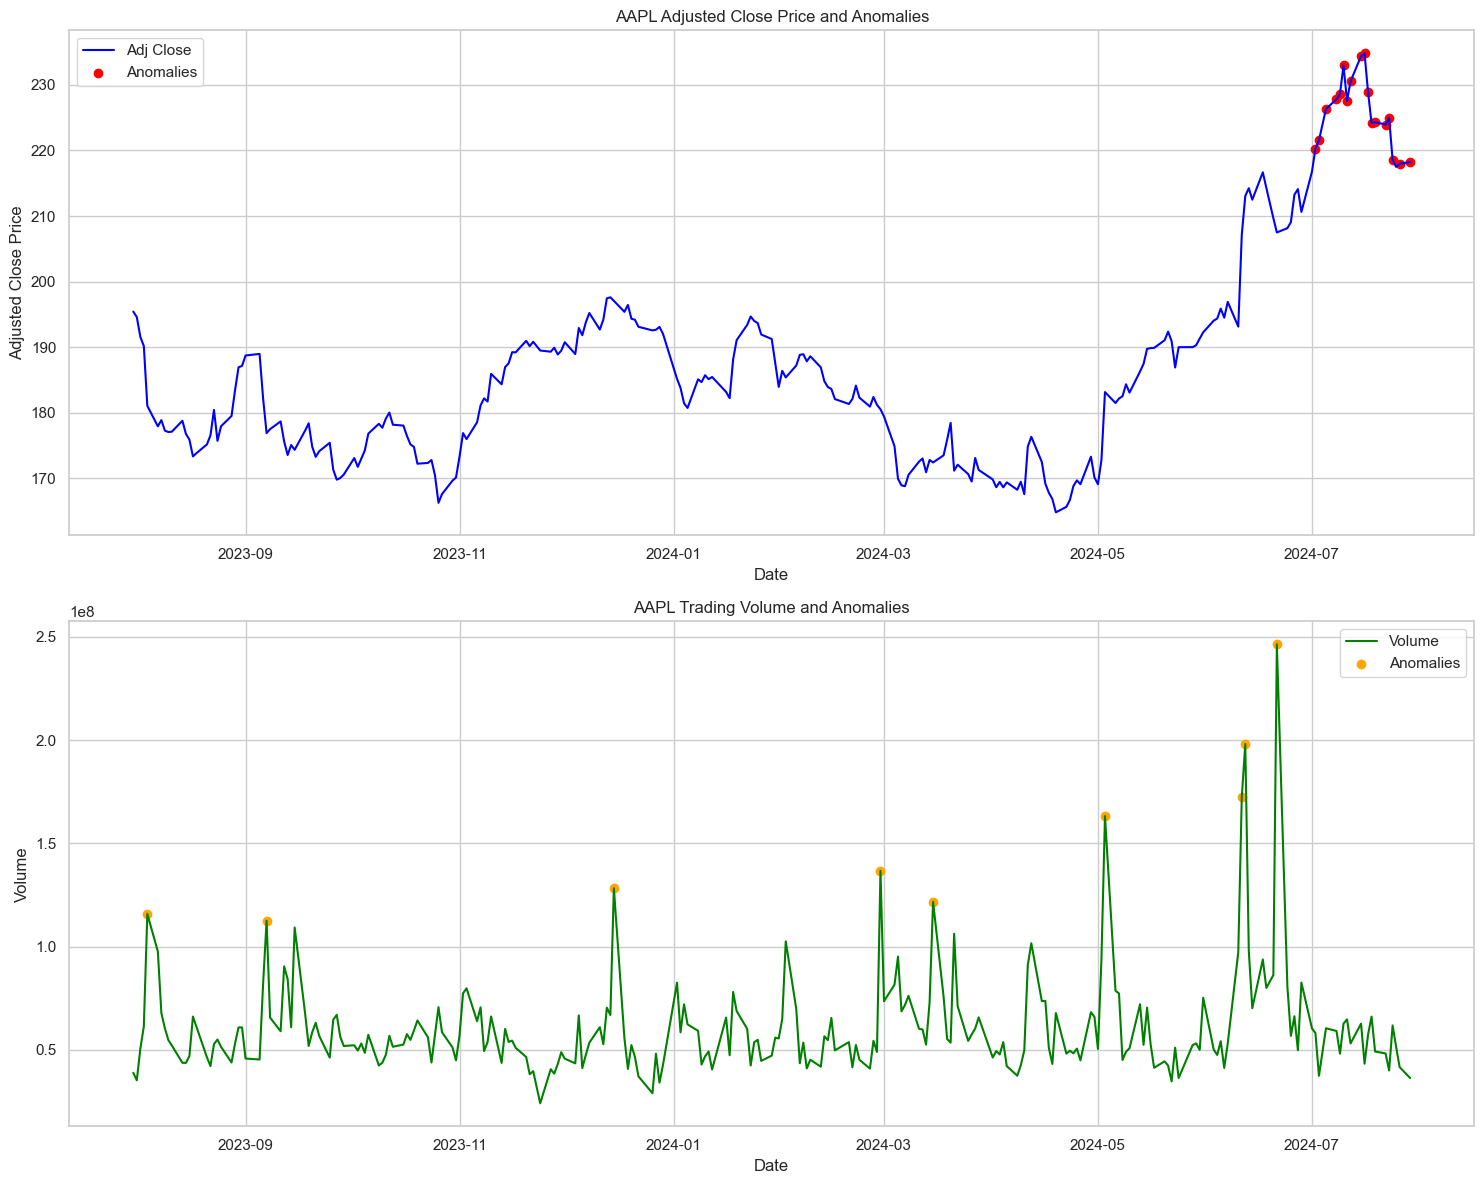

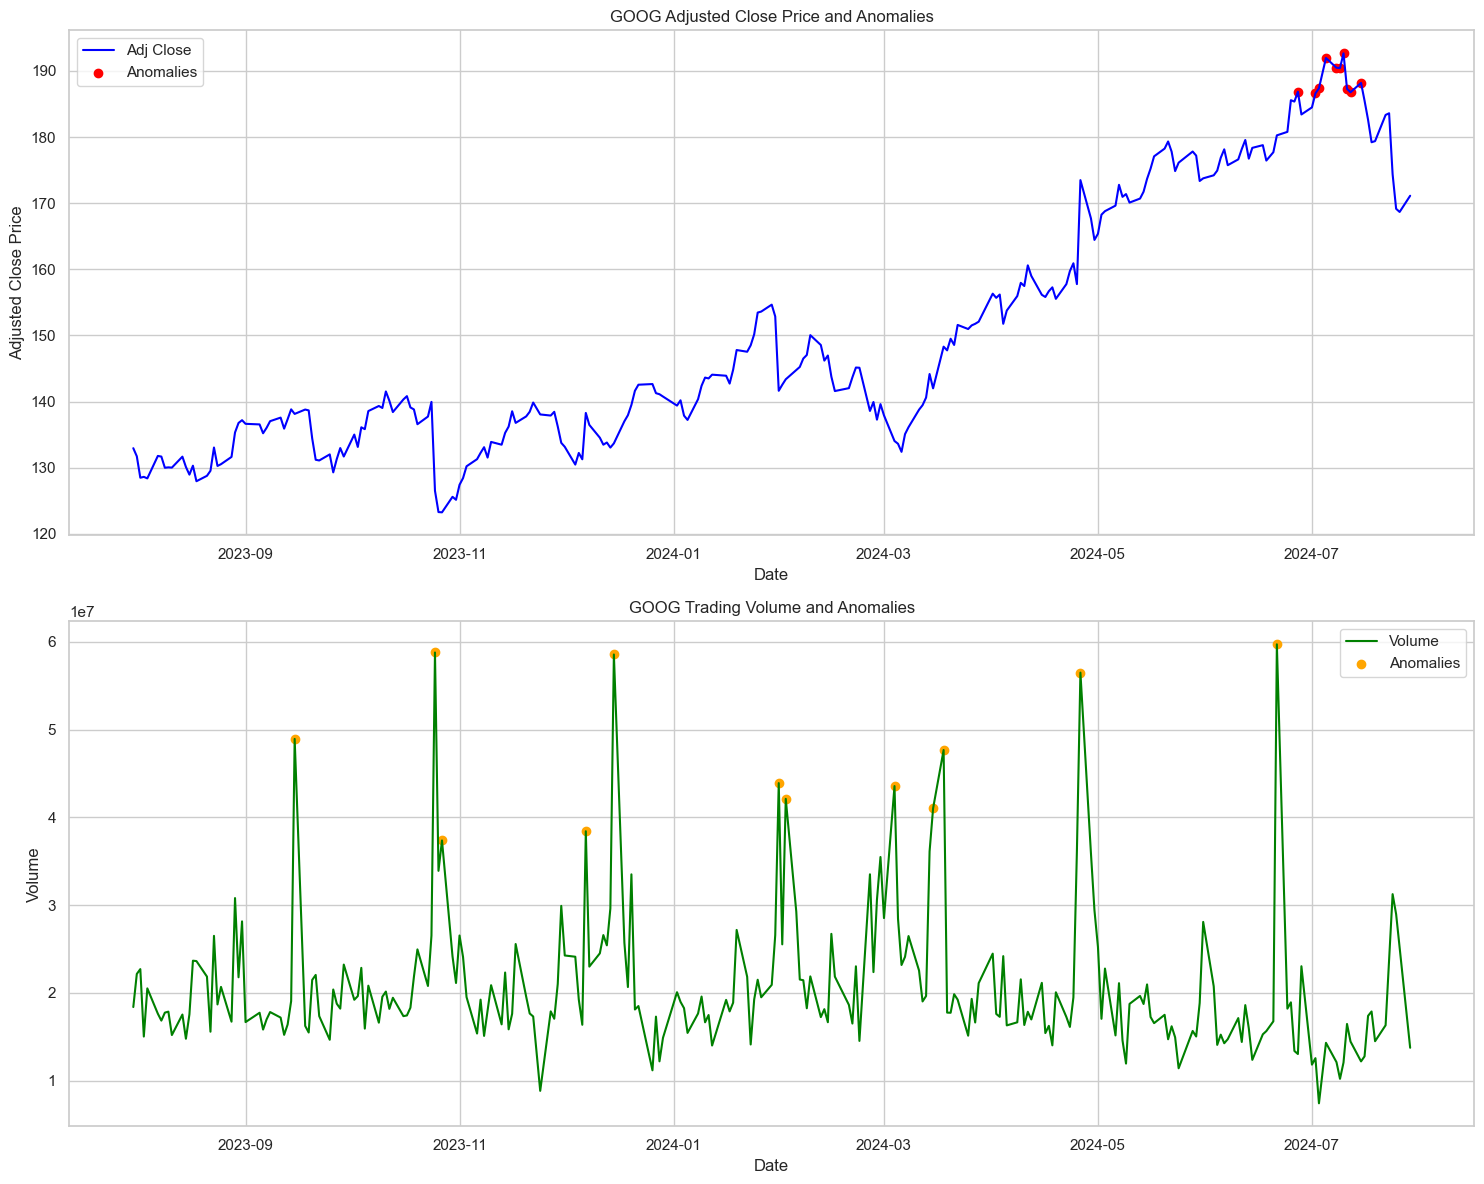

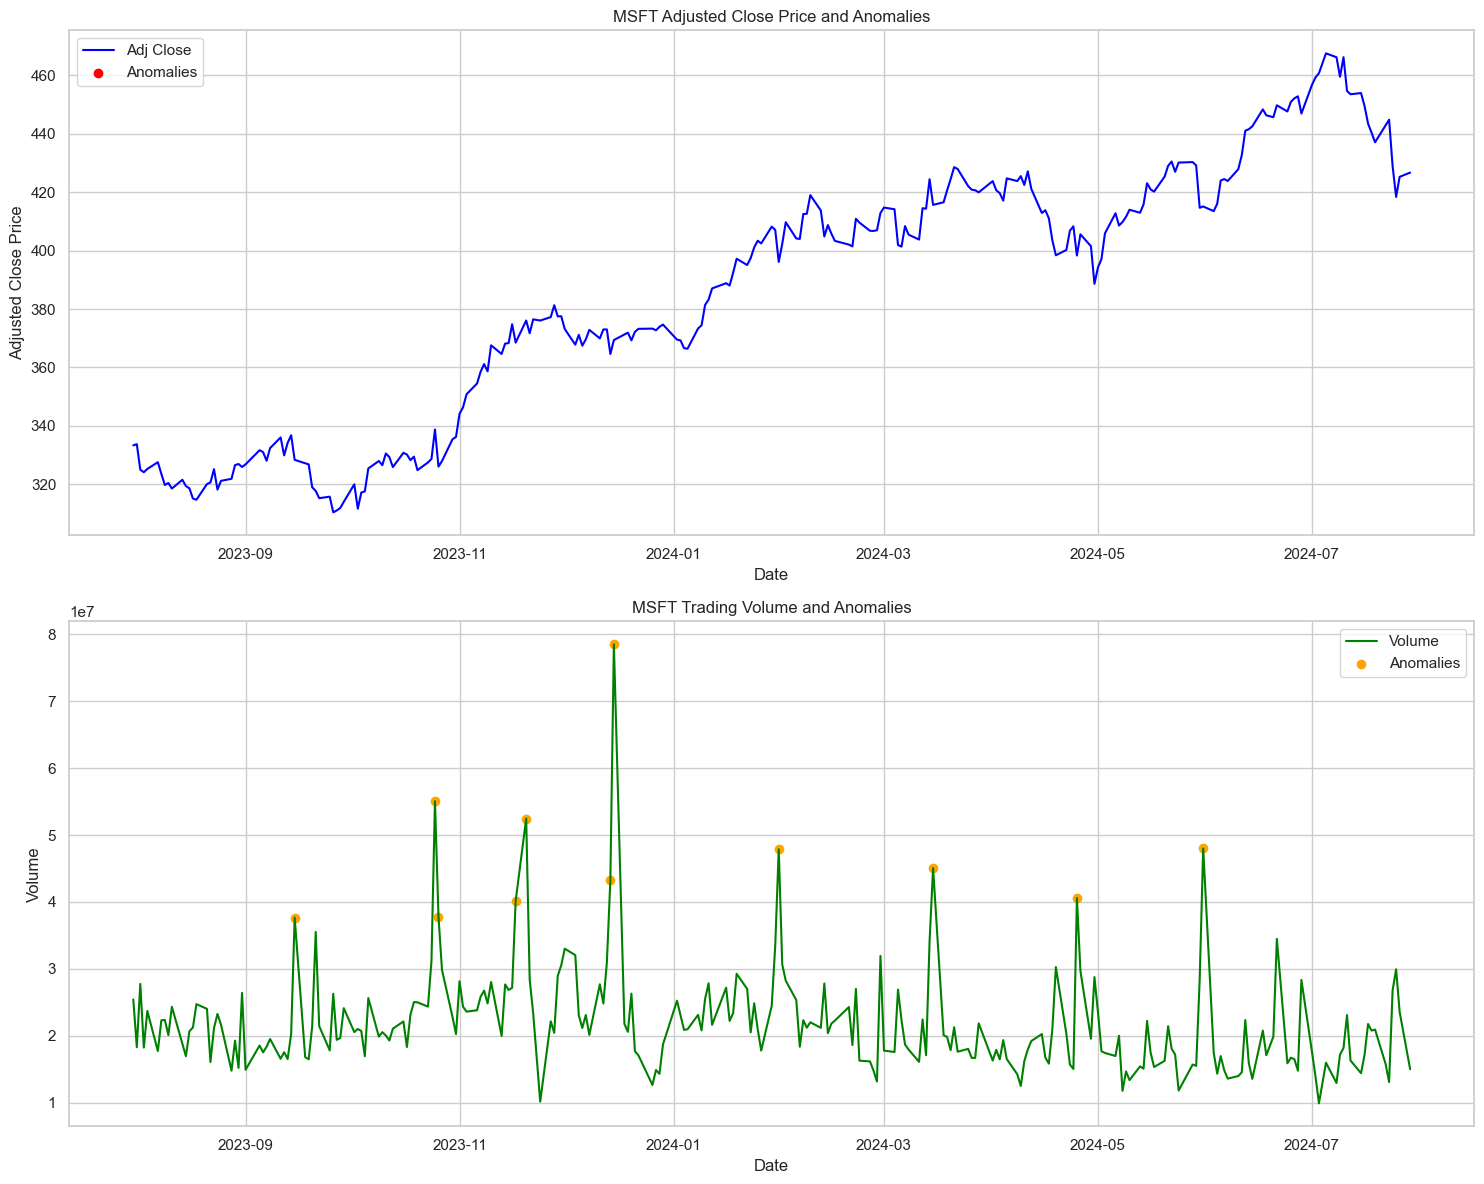

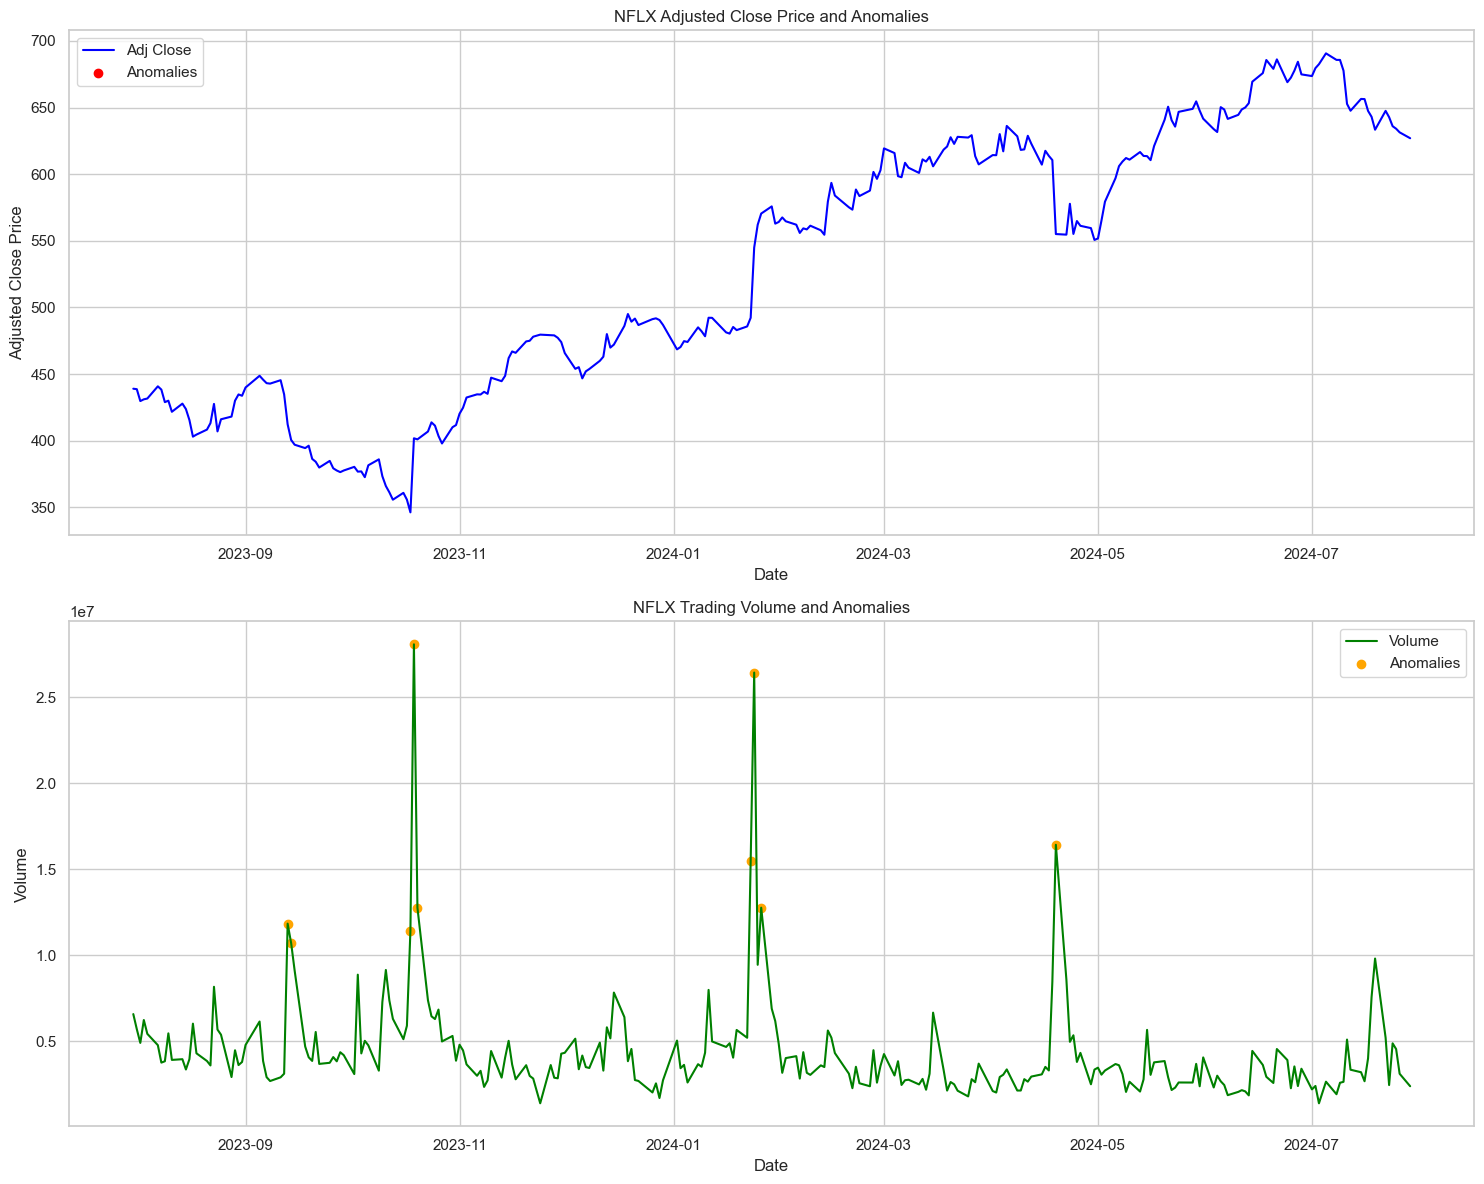

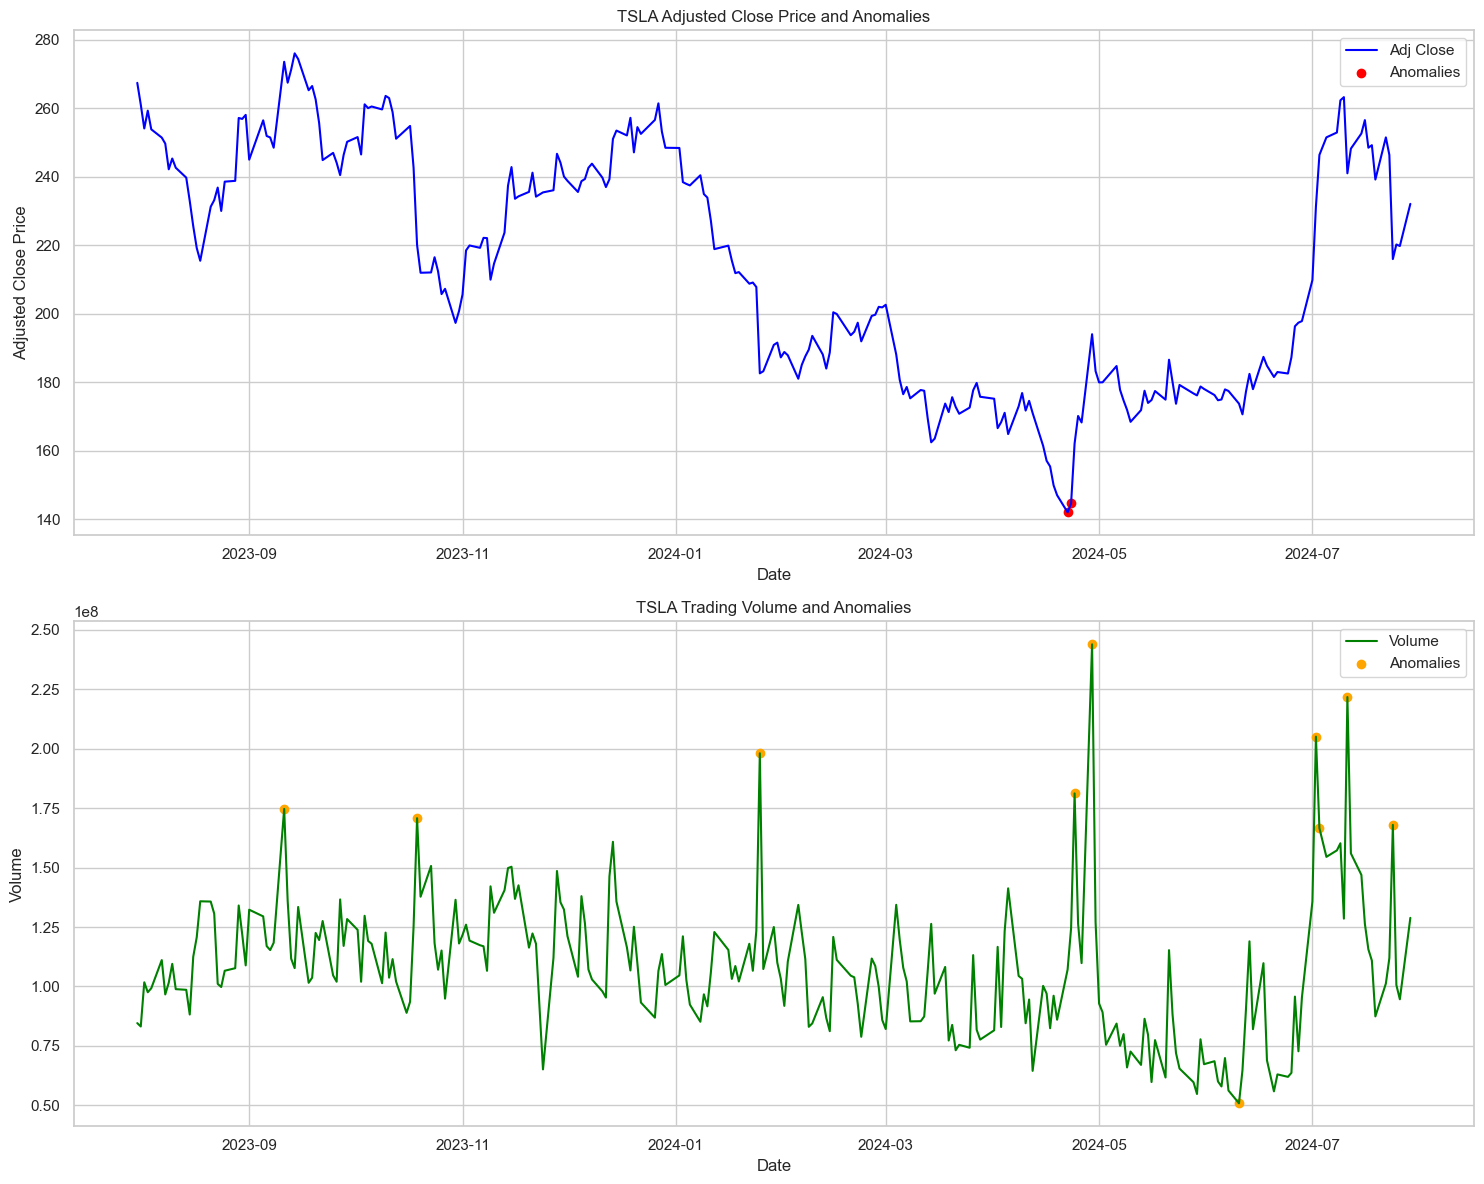

In [5]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [6]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly                     Volume Anomaly  \
Ticker                                AAPL      GOOG      TSLA           AAPL   
                  Ticker                                                        
Adj Close Anomaly AAPL            1.000000  0.116775 -0.794719            NaN   
                  GOOG            0.116775  1.000000 -0.309344            NaN   
                  TSLA           -0.794719 -0.309344  1.000000            NaN   
Volume Anomaly    AAPL                 NaN       NaN       NaN       1.000000   
                  GOOG                 NaN       NaN       NaN       0.055048   
                  MSFT                 NaN       NaN       NaN      -0.047134   
                  NFLX                 NaN       NaN       NaN      -0.272727   
                  TSLA                 NaN       NaN       NaN      -0.291937   

                                                                  
Ticker                        GOOG      M

In [7]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    1.000000
GOOG    0.398025
MSFT         NaN
NFLX         NaN
TSLA    0.000000
Name: Z-score, dtype: float64
